# LSA - Code

## Building the Term / Document matrix
LSA is a natural language processing method, it helps analysing a corpus of texts. A corpus of text is simply a collection of texts, to understand what follows we introduce a few terms :
* *Corpus :* the collection of texts to be analysed
* *Document :* how we will call a text in the corpus
* *Term :* how we will call individual words in the corpus

The object we need to build in order to run the LSA model is a term-document matrix, it is a matrix which rows represent all the words present in the corpus, the columns represent each document in the corpus, and the values contained in the matrix indicate a certain metric that quantifies the link between a given term with a given document. For example this metric may be the number of times that the term appears in a document. More commonly the metric that is used to build the term/document matrix is the term frequency inverse document frequency introduced in the first lecture (TfIdf) because of its ability to more accurately represent the relevance of each term in each document.

Let's create a toy example of corpus and walk you through the steps of building the term document matrix :

In [29]:
# Install spacy quietly
!pip install spacy -q

In [82]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

# List of documents
a1 = "He is a good dog."
a2 = "The dog is too lazy."
a3 = "That is a brown cat."
a4 = "Cats are very active."
a5 = "I have brown cat and dog."

df = pd.DataFrame()
df["documents"] = [a1,a2,a3,a4,a5]
df

,documents
0,He is a good dog.
1,The dog is too lazy.
2,That is a brown cat.
3,Cats are very active.
4,I have brown cat and dog.


We are now going to run simple preprocessing on this simple corpus to make it suitable for our model :
* remove all special characters 
* convert all characters to lowercase

In [83]:
!python -m spacy download en -q

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [84]:
# Importing english
import en_core_web_sm
nlp = en_core_web_sm.load()

In [85]:
df["documents"]

0            He is a good dog.
1         The dog is too lazy.
2         That is a brown cat.
3        Cats are very active.
4    I have brown cat and dog.
Name: documents, dtype: object

In [86]:
df["clean_documents"] = df['documents'].str.replace(r"[^A-Za-z0-9 ]+", " ").str.lower()

/tmp/ipykernel_264/393400321.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["clean_documents"] = df['documents'].str.replace(r"[^A-Za-z0-9 ]+", " ").str.lower()


In [87]:
df["clean_documents"]

0            he is a good dog 
1         the dog is too lazy 
2         that is a brown cat 
3        cats are very active 
4    i have brown cat and dog 
Name: clean_documents, dtype: object

In [4]:
df['clean_documents'] = df['documents'].str.replace(r"[^A-Za-z0-9 ]+", " ").str.lower()

/tmp/ipykernel_264/1301241186.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_documents'] = df['documents'].str.replace(r"[^A-Za-z0-9 ]+", " ").str.lower()


In [5]:
# Preprocessing
#df['clean_documents'] = df['documents'].str.replace(r"[^A-Za-z0-9 ]+", " ")
#df['clean_documents'] = df['clean_documents'].apply(lambda x: x.lower())
#df

Now that the text has been preprocessed, we will proceed to tokenization, which is the process of isolating each word in each document as a token, this will be a good opportunity to remove stop words tokens.

In [38]:
df

,documents,clean_documents
0,He is a good dog.,he is a good dog
1,The dog is too lazy.,the dog is too lazy
2,That is a brown cat.,that is a brown cat
3,Cats are very active.,cats are very active
4,I have brown cat and dog.,i have brown cat and dog


In [41]:
for token in nlp(df.loc[0]["clean_documents"]):
    if token.lemma_ not in STOP_WORDS:
        print(token.lemma_)

good
dog


In [88]:
def process_text(x):
    spacied = nlp(x)
    new_sentence = []
    for token in spacied:
        if token.lemma_.lower() not in STOP_WORDS:
            new_sentence.append(token.lemma_.lower())
    return  " ".join(new_sentence)        

df["processed_documents"] = df["clean_documents"].apply(process_text)

In [90]:
df["clean_documents"].apply(process_text)

0         good dog
1         dog lazy
2        brown cat
3       cat active
4    brown cat dog
Name: clean_documents, dtype: object

In [91]:
from spacy.lang.en.stop_words import STOP_WORDS

tokenized_doc = df['clean_documents'].apply(lambda x: nlp(x))

tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_doc

0          [good, dog]
1          [dog, lazy]
2         [brown, cat]
3        [cat, active]
4    [brown, cat, dog]
Name: clean_documents, dtype: object

Now that all our documents have been tokenized and cleaned, it is time to create ou term-document matrix giving the tf-idf for each term in each document. But first we have to re inject the cleaned documents in the DataFrame.

In [7]:
df["clean_documents"] = tokenized_doc.apply(lambda x: ' '.join(x))
df

,documents,clean_documents
0,He is a good dog.,good dog
1,The dog is too lazy.,dog lazy
2,That is a brown cat.,brown cat
3,Cats are very active.,cat active
4,I have brown cat and dog.,brown cat dog


In [92]:
df["processed_documents"]

0         good dog
1         dog lazy
2        brown cat
3       cat active
4    brown cat dog
Name: processed_documents, dtype: object

In [93]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_documents'])

In [52]:
X

<5x6 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [54]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,active,brown,cat,dog,good,lazy
0,0.000000,0.000000,0.000000,0.556451,0.830881,0.000000
1,0.000000,0.000000,0.000000,0.556451,0.000000,0.830881
2,0.000000,0.769447,0.638711,0.000000,0.000000,0.000000
3,0.830881,0.000000,0.556451,0.000000,0.000000,0.000000
4,0.000000,0.648463,0.538283,0.538283,0.000000,0.000000


Note that the obtained object is a sparse matrix. This format is often used when dealing with matrices with a very high number of elements equal to zero to save memory space and accelerate computation. The only drawback is that sparse object cannot be visualized.

## Apply truncatedSVD

Remember from theory that truncated SVD means that we can take the $k$ highest singular values to approximates a matrix $A$. 

Now if we only wish to select the highest $k$ out of the $l$ singular values $\sigma_1, ..., \sigma_l$ as well as the corresponding vectors from $U$ and $V$ we would obtain the best rank $k$ approximation of X, and we could map the word vector $t_i^T$ to its $k$ rank approxiamtion $\hat{t_i^T}_{(k)}$, and $\hat{d_j}$ to its $k$ rank approximation $\hat{d_j}_{(k)}$

You can now do the following:

* See how related documents $j$ and $q$ are in the low-dimensional space by comparing the vectors $\Sigma_{k} \hat{d_{j}}$ and $\Sigma_{k}\hat{d_q}$ (typically by [cosine similarity](https://en.wikipedia.org/wiki/Vector_space_model)).
* Comparing terms $i$ and $p$ by comparing the vectors $\Sigma_{k}\hat{t_{i}}$ and $\Sigma_{k}\hat{t_{p}}$. Note that $\hat{t}$ is now a column vector.
* Documents and term vector representations can be clustered using traditional clustering algorithms like k-means using similarity measures like cosine.

The $k$ dimensions retained for the low dimensional space are often referred to as topics even though their interpretation may be difficult.

Let's see how we can use the SVD in python in order to understand our corpus:



In [95]:
svd_model = TruncatedSVD(n_components=5, n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

In [97]:
topic_encoded_df = pd.DataFrame(lsa, columns = [f"topic_{i}" for i in range(5)])
topic_encoded_df["documents"] = df['processed_documents']
topic_encoded_df

,topic_0,topic_1,topic_2,topic_3,topic_4,documents
0,0.341383,0.719978,0.132267,-5.875214e-01,-0.049121,good dog
1,0.341383,0.719978,0.132267,5.875214e-01,-0.049121,dog lazy
2,0.860949,-0.365984,-0.299524,-4.718449e-16,-0.187371,brown cat
3,0.516666,-0.385005,0.764710,1.112297e-15,0.006768,cat active
4,0.949412,0.023630,-0.239656,-4.562219e-16,0.201554,brown cat dog


In [58]:
topic_encoded_df[["topic_1", "topic_2"]].loc[0]

topic_1    0.341383
topic_2    0.719978
Name: 0, dtype: float64

In [59]:
topic_encoded_df[["topic_1", "topic_2"]].loc[1]

topic_1    0.341383
topic_2    0.719978
Name: 1, dtype: float64

In [62]:
from scipy import spatial

d1 = topic_encoded_df[["topic_1", "topic_2"]].loc[0]
d2 = topic_encoded_df[["topic_1", "topic_2"]].loc[1]
result = 1 - spatial.distance.cosine(d1, d2)

In [64]:

d1 = topic_encoded_df[["topic_1", "topic_2"]].loc[0]
d2 = topic_encoded_df[["topic_1", "topic_2"]].loc[3]
result = 1 - spatial.distance.cosine(d1, d2)

In [65]:
result

-0.19635821138246023

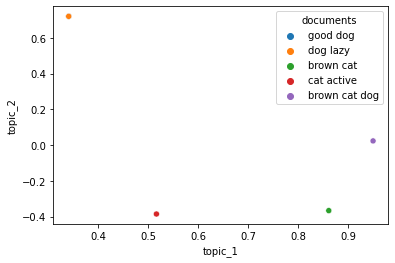

In [66]:
sns.scatterplot(x="topic_1", y="topic_2", data= topic_encoded_df, hue = "documents");

In [19]:
topic_encoded_df

,topic_1,topic_2,documents
0,0.341383,0.719978,good dog
1,0.341383,0.719978,dog lazy
2,0.860949,-0.365984,brown cat
3,0.516666,-0.385005,cat active
4,0.949412,0.023630,brown cat dog


In [80]:
pd.DataFrame(svd_model.components_, columns=vectorizer.get_feature_names_out()).T.rename(columns={0:"topic_1", 1:"topic_2"})

,topic_1,topic_2
active,0.200354,-0.242441
brown,0.596512,-0.201810
cat,0.629338,-0.329886
dog,0.415831,0.616903
good,0.132383,0.453377
lazy,0.132383,0.453377


In [74]:
pd.DataFrame(svd_model.components_).T.rename(columns={0:"topic_1", 1:"topic_2"})

,topic_1,topic_2
0,0.200354,-0.242441
1,0.596512,-0.201810
2,0.629338,-0.329886
3,0.415831,0.616903
4,0.132383,0.453377
5,0.132383,0.453377


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='topic_1', ylabel='topic_2'>

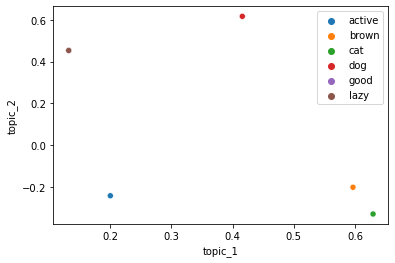

In [12]:
topic = pd.DataFrame(svd_model.components_, index = ["topic_1","topic_2"])
topic.columns= vectorizer.get_feature_names() 
topic_t = topic.transpose()

import seaborn as sns
sns.scatterplot("topic_1","topic_2",data= topic_t, hue = topic_t.index)

In [103]:
"SUBJECT: lalalalalal".split("SUBJECT")[1]

': lalalalalal'

In [101]:
svd_model.explained_variance_ratio_.sum()

1.0000000000000004

In [16]:
svd_model.components_

array([[ 0.20035413,  0.59651171,  0.6293381 ,  0.4158308 ,  0.1323826 ,
         0.1323826 ],
       [-0.24244085, -0.2018099 , -0.32988591,  0.61690333,  0.45337665,
         0.45337665]])

For example here, we used the SVD in order to approximate the term-document matrix with a decomposition of rank 2, and we can see how each document (sentence) is projected across these two topics.

Here we notice that topic 1 tends to be more linked to cat and topic 2 is more linked with dog.

## Resources 📚📚

*   <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html?highlight=truncated%20svd#sklearn.decomposition.TruncatedSVD" target="_blank">Truncated SVD</a>

*   <a href="https://scikit-learn.org/stable/modules/decomposition.html#lsa" target="_blank">Truncated singular value decomposition and latent semantic analysis</a>